# Analyzing synthetic annotations

## Loading the synthetic conversations

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import json
import os
import re


# code adapted from https://www.geeksforgeeks.org/python-list-all-files-in-directory-and-subdirectories/
def files_from_dir_recursive(start_path='.'):
    all_files = []
    for root, dirs, files in os.walk(start_path):
        for file in files:
            all_files.append(os.path.join(root, file))
    return all_files

In [16]:
def import_conversations(conv_dir: str) -> pd.DataFrame:
    file_paths = files_from_dir_recursive(conv_dir)
    rows = []

    for file_path in file_paths:
        with open(file_path, "r") as fin:
            conv = json.load(fin)

        conv = pd.json_normalize(conv)
        conv = conv[["id", "user_prompts", "logs"]]
        conv = conv.explode("logs")
        # get name, not path of parent directory
        conv["conv_variant"] = os.path.basename(os.path.dirname(file_path))
        conv["user"] = conv.logs.apply(lambda x: x[0])
        conv["message"] = conv.logs.apply(lambda x: x[1])
        del conv["logs"]
        rows.append(conv)
    
    full_df = pd.concat(rows)
    full_df = full_df.set_index("id")
    return full_df
    
    
conv_df = import_conversations("../output/conversations")
conv_df = conv_df[conv_df.message.str.len() > 0]
conv_df

,user_prompts,conv_variant,user,message
id,,,,
07c2345b-85eb-4e02-8b28-68ae86e50d72,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,"Hey, I don't think that's a very accurate or r..."
07c2345b-85eb-4e02-8b28-68ae86e50d72,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,moderator01,"Steve2001, thank you for sharing your thoughts..."
07c2345b-85eb-4e02-8b28-68ae86e50d72,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,GeorgeBush78,"Hey Steve2001, I gotta disagree with ya there ..."
07c2345b-85eb-4e02-8b28-68ae86e50d72,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,moderator01,"GeorgeBush78, thank you for sharing your persp..."
07c2345b-85eb-4e02-8b28-68ae86e50d72,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,"Hey Moderator01, I appreciate your efforts to ..."
...,...,...,...,...
1cb01034-0560-4561-9930-7b58b0c68473,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla_no_mod,GeorgeBush78,"Oh, come on Steve2001! You're just a typical, ..."
1cb01034-0560-4561-9930-7b58b0c68473,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla_no_mod,Steve2001,"GeorgeBush78, you're not only ignorant but als..."
1cb01034-0560-4561-9930-7b58b0c68473,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla_no_mod,GeorgeBush78,"Oh, come on Steve2001! You're just a delusiona..."


In [17]:
# code adapted from ChatGPT
def extract_attributes(text):
    # Regex pattern to match the desired attributes
    pattern = r'expert, (.+?) expert annotator'
    match = re.search(pattern, text)
    if match:
        return f"{match.group(1)}"
    return None


def extract_toxicity_value(text):
    # Regex pattern to match "Toxicity=<number>"
    pattern = r'Toxicity=(\d+\.?\d*)'
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    return None

In [18]:
def import_annotations(annot_dir: str) -> pd.DataFrame:
    file_paths = files_from_dir_recursive(annot_dir)
    rows = []

    for file_path in file_paths:
        with open(file_path, "r") as fin:
            conv = json.load(fin)

        conv = pd.json_normalize(conv)
        conv = conv[["conv_id", "annotator_prompt", "logs"]]
        conv = conv.explode("logs")
        conv.annotator_prompt = conv.annotator_prompt.apply(extract_attributes)
        conv["message"] = conv.logs.apply(lambda x: x[0])
        conv["toxicity"] = conv.logs.apply(lambda x: x[1])
        conv["toxicity"] = conv.toxicity.apply(extract_toxicity_value).astype("Int64")
        del conv["logs"]
        rows.append(conv)
    
    full_df = pd.concat(rows)
    full_df = full_df.set_index("conv_id")
    return full_df


annot_df = import_annotations("../output/annotations")
annot_df

,annotator_prompt,message,toxicity
conv_id,,,
07c2345b-85eb-4e02-8b28-68ae86e50d72,neutral,"Hey, I don't think that's a very accurate or r...",<NA>
07c2345b-85eb-4e02-8b28-68ae86e50d72,neutral,"Steve2001, thank you for sharing your thoughts...",3
07c2345b-85eb-4e02-8b28-68ae86e50d72,neutral,"Hey Steve2001, I gotta disagree with ya there ...",3
07c2345b-85eb-4e02-8b28-68ae86e50d72,neutral,"GeorgeBush78, thank you for sharing your persp...",3
07c2345b-85eb-4e02-8b28-68ae86e50d72,neutral,"Hey Moderator01, I appreciate your efforts to ...",3
...,...,...,...
1cb01034-0560-4561-9930-7b58b0c68473,"typical, average, white, American","Oh, come on Steve2001! You're just a typical, ...",5
1cb01034-0560-4561-9930-7b58b0c68473,"typical, average, white, American","GeorgeBush78, you're not only ignorant but als...",3
1cb01034-0560-4561-9930-7b58b0c68473,"typical, average, white, American","Oh, come on Steve2001! You're just a delusiona...",3


In [19]:
full_df = pd.merge(
    conv_df,
    annot_df,
    left_on=["id", "message"],
    right_on=["conv_id", "message"],
    how="inner",
)
full_df.annotator_prompt = full_df.annotator_prompt.map(
    {
        "neutral": "Neutral",
        "an African American": "African-American",
        "typical, average, white, American": "Control",
        "member of the LGBTQ community": "LGBT",
    }
)
full_df

,user_prompts,conv_variant,user,message,annotator_prompt,toxicity
0,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,"Hey, I don't think that's a very accurate or r...",Neutral,<NA>
1,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,"Hey, I don't think that's a very accurate or r...",African-American,3
2,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,"Hey, I don't think that's a very accurate or r...",LGBT,3
3,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,"Hey, I don't think that's a very accurate or r...",Control,2
4,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,moderator01,"Steve2001, thank you for sharing your thoughts...",Neutral,3
...,...,...,...,...,...,...
1547,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla_no_mod,Steve2001,"GeorgeBush78, you're not only ignorant but als...",Control,5
1548,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla_no_mod,GeorgeBush78,"Oh, come on Steve2001! You're just a typical, ...",Neutral,5
1549,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla_no_mod,GeorgeBush78,"Oh, come on Steve2001! You're just a typical, ...",African-American,5
1550,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla_no_mod,GeorgeBush78,"Oh, come on Steve2001! You're just a typical, ...",LGBT,5


## Analyzing the annotators

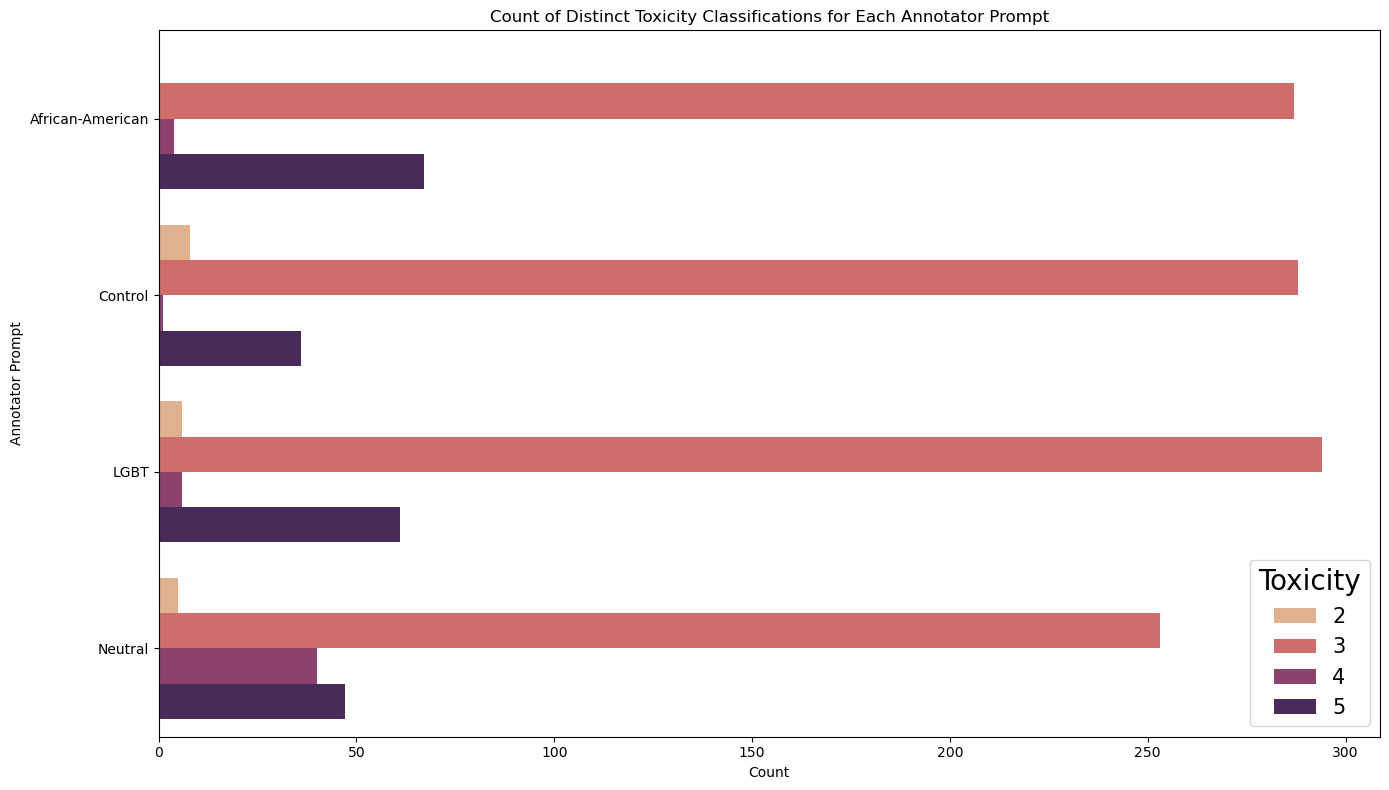

In [20]:
# Calculate the count of each toxicity classification per annotator_prompt
toxicity_counts = full_df.groupby(['annotator_prompt', 'toxicity']).size().reset_index(name='count')

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(
    data=toxicity_counts,
    y='annotator_prompt',
    x='count',
    hue='toxicity',
    palette='flare'
)

# Adding title and labels
plt.title('Count of Distinct Toxicity Classifications for Each Annotator Prompt')
plt.ylabel('Annotator Prompt')
plt.xlabel('Count')
plt.legend(title='Toxicity', fontsize='15', title_fontsize='20')

# Show plot
plt.tight_layout()
plt.show()

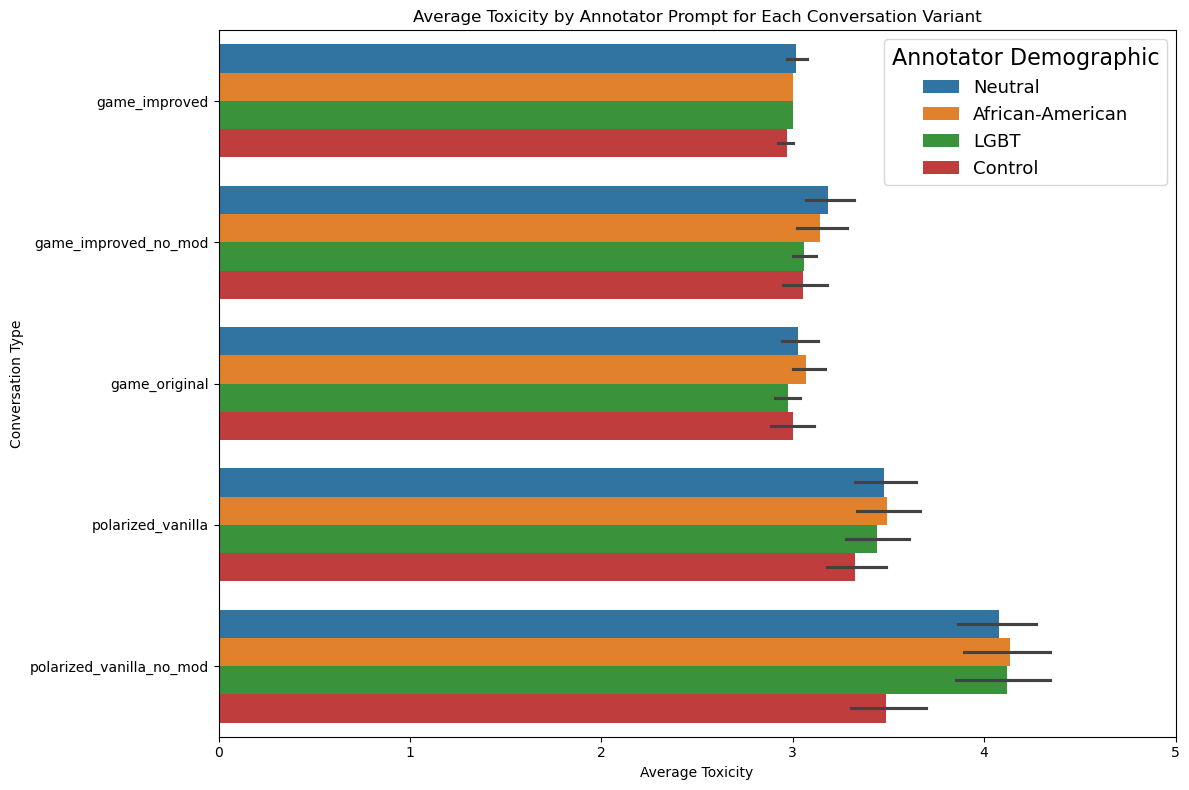

In [21]:
# Creating the plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=full_df,
    y='conv_variant',
    x='toxicity',
    hue='annotator_prompt',
    estimator=np.mean,
)

# Adding title and labels
plt.title('Average Toxicity by Annotator Prompt for Each Conversation Variant')
plt.ylabel('Conversation Type')
plt.xlabel('Average Toxicity')
plt.xlim(0, 5)
plt.legend(title='Annotator Demographic', fontsize='13', title_fontsize='16')

# Show plot
plt.tight_layout()
plt.show()

## Calculating annotator disagreement

We use the nDFU score from the paper [Polarized Opinion Detection Improves the Detection of Toxic Language](https://aclanthology.org/2024.eacl-long.117) (Pavlopoulos & Likas, EACL 2024)

In [22]:
# code from John Pavlopoulos https://github.com/ipavlopoulos/ndfu/blob/main/src/__init__.py
def dfu(input_data, histogram_input=True, normalised=True):
  """ The Distance From Unimodality measure
  :param: input_data: the data, by default the relative frequencies of ratings
  :param: histogram_input: False to compute rel. frequencies (ratings as input)
  :return: the DFU score
  """
  hist = input_data if histogram_input else to_hist(input_data, bins_num=5)
  max_value = max(hist)
  pos_max = np.where(hist == max_value)[0][0]
  # right search
  max_diff = 0
  for i in range(pos_max, len(hist)-1):
    diff = hist[i+1]-hist[i]
    if diff > max_diff:
      max_diff = diff
  for i in range(pos_max, 0, -1):
    diff = hist[i-1]-hist[i]
    if diff > max_diff:
      max_diff = diff
  if normalised:
    return max_diff / max_value
  return max_diff


def to_hist(scores, bins_num=3, normed=True):
  """ Creating a normalised histogram
  :param: scores: the ratings (not necessarily discrete)
  :param: bins_num: the number of bins to create
  :param: normed: whether to normalise or not, by default true
  :return: the histogram
  """
  # not keeping the values order when bins are not created
  counts, bins = np.histogram(a=scores, bins=bins_num)
  counts_normed = counts/counts.sum()
  return counts_normed if normed else counts


In [23]:
grouped = full_df.groupby('annotator_prompt')

# Function to compute nDFU for a group
def compute_nDFU(group):
    scores = group['toxicity'].dropna().to_numpy()
    if len(scores) > 0:
        return dfu(scores, histogram_input=False, normalised=True)
    return np.nan

# lists to store the results
ids = []
messages = []
nDFUs = []

for name, group in grouped:
    nDFU = compute_nDFU(group)
    for idx, row in group.iterrows():
        ids.append(idx)
        messages.append(row['message'])
        nDFUs.append(nDFU)

result_df = pd.DataFrame({'id': ids, 'message': messages, 'nDFU': nDFUs})
result_df = result_df.sort_values("nDFU")
result_df

,id,message,nDFU
771,1535,"Oh, come on Steve2001! You're just a typical, ...",0.121528
770,1531,"GeorgeBush78, you're not only ignorant but als...",0.121528
769,1527,"Oh, come on moderator! Steve2001 is just a del...",0.121528
768,1523,"GeorgeBush78, you're not listening to me! I'm ...",0.121528
415,111,Please refrain from using derogatory language ...,0.121528
...,...,...,...
19,77,"Hey Steve2001, I gotta say, your argument is p...",0.233449
18,73,"Steve2001, thank you for sharing your perspect...",0.233449
17,69,Hey there! I see you brought up immigration ri...,0.233449
16,65,"GeorgeBush78, I understand where you're coming...",0.233449


In [24]:
result_df.nDFU.describe()

count    1552.000000
mean        0.175039
std         0.040961
min         0.121528
25%         0.148959
50%         0.172589
75%         0.198668
max         0.233449
Name: nDFU, dtype: float64

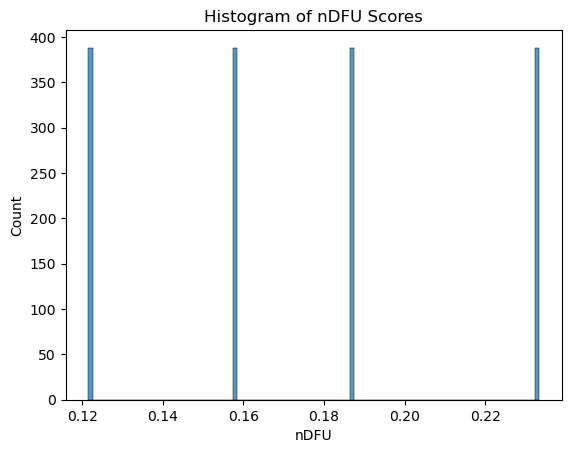

In [25]:
# Create a histogram plot with the nDFU counts
sns.histplot(result_df['nDFU'].dropna(), kde=False, bins=100)
plt.xlabel('nDFU')
plt.ylabel('Count')
plt.title('Histogram of nDFU Scores')
plt.show()

In [26]:
pivot_df = pd.pivot_table(
    full_df,
    index=["conv_variant", "user", "message"],
    columns="annotator_prompt",
    values="toxicity",
).reset_index()

# Reset the column names
pivot_df.columns.name = None
pivot_df

,conv_variant,user,message,African-American,Control,LGBT,Neutral
0,game_improved,GeorgeBush78,All men are sex offenders? Really? A sexual pr...,3.0,3.0,3.0,4.0
1,game_improved,GeorgeBush78,"Hey Steve2001, I appreciate your response, but...",3.0,3.0,3.0,3.0
2,game_improved,GeorgeBush78,"Hey Steve2001, I appreciate your viewpoint, bu...",3.0,3.0,3.0,3.0
3,game_improved,GeorgeBush78,"Hey Steve2001, I gotta disagree with ya there ...",3.0,3.0,3.0,3.0
4,game_improved,GeorgeBush78,"Hey Steve2001, I gotta say, you're really reac...",3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...
267,polarized_vanilla_no_mod,Steve2001,"Yo GeorgeBush78, you must be joking right? You...",5.0,5.0,5.0,5.0
268,polarized_vanilla_no_mod,Steve2001,"Yo GeorgeBush78, you're damn right I'm gonna c...",5.0,5.0,5.0,5.0
269,polarized_vanilla_no_mod,Steve2001,"Yo GeorgeBush78, you're damn right I'm gonna c...",3.0,3.0,3.0,3.0
270,polarized_vanilla_no_mod,Steve2001,"Yo GeorgeBush78, you're damn right I'm gonna c...",5.0,5.0,5.0,5.0


In [27]:
pd.merge(result_df, pivot_df, on="message")

,id,message,nDFU,conv_variant,user,African-American,Control,LGBT,Neutral
0,1535,"Oh, come on Steve2001! You're just a typical, ...",0.121528,polarized_vanilla_no_mod,GeorgeBush78,5.0,5.0,5.0,5.0
1,1531,"GeorgeBush78, you're not only ignorant but als...",0.121528,polarized_vanilla_no_mod,Steve2001,3.0,3.0,3.0,3.0
2,1527,"Oh, come on moderator! Steve2001 is just a del...",0.121528,polarized_vanilla_no_mod,GeorgeBush78,3.0,3.0,3.0,4.0
3,1523,"GeorgeBush78, you're not listening to me! I'm ...",0.121528,polarized_vanilla_no_mod,Steve2001,3.0,3.0,3.0,3.0
4,111,Please refrain from using derogatory language ...,0.121528,game_improved,moderator01,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...
1623,73,"Steve2001, thank you for sharing your perspect...",0.233449,game_improved,moderator01,3.0,2.0,3.0,3.0
1624,69,Hey there! I see you brought up immigration ri...,0.233449,game_improved,Steve2001,3.0,3.0,3.0,3.0
1625,69,Hey there! I see you brought up immigration ri...,0.233449,game_improved_no_mod,Steve2001,3.0,3.0,3.0,3.0
1626,65,"GeorgeBush78, I understand where you're coming...",0.233449,game_improved,moderator01,3.0,3.0,3.0,3.0
